## Задача
...


## Описание датасета:

Этот набор данных связан с красными вариантами португальского вина "Vinho Verde". Набор данных описывает количество различных химических веществ, присутствующих в вине, и их влияние на его качество. 

- `fixed acidity`: фиксированная кислотность;

- `volatile acidity`: летучая кислотность;

- `citric acid`: лимонная кислота;

- `residual sugar`: остаточный сахар;

- `chlorides`: хлориды;

- `free sulfur dioxide`: свободный диоксид серы;

- `total sulfur dioxide`: общий диоксид серы;

- `density`: плотность;

- `pH`:  

- `sulphates`: сульфаты;

- `alcohol`: спирт;

- `quality`: качество (оценка от 0 до 10);



## Что входит в практическую работу
1.  
2.  
3.  
4.  


## Импорт необходимых бибилиотек

In [ ]:
!pip install missingno
import missingno as msno  # https://github.com/ResidentMario/missingno

In [ ]:
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn # игнорировать предупреждения (from sklearn and seaborn)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel


## Загрузка датасета https://www.kaggle.com/datasets/rajyellow46/wine-quality

In [ ]:
def dataset_loading(path): # функция загрузки данных и удаления дубликатов
    df = pd.read_csv(path)
    df.drop_duplicates(inplace=True)
    return df

In [ ]:
df = pd.read_csv('winequalityN.csv')
df

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0     white            7.0             0.270         0.36            20.7   
1     white            6.3             0.300         0.34             1.6   
2     white            8.1             0.280         0.40             6.9   
3     white            7.2             0.230         0.32             8.5   
4     white            7.2             0.230         0.32             8.5   
...     ...            ...               ...          ...             ...   
6492    red            6.2             0.600         0.08             2.0   
6493    red            5.9             0.550         0.10             2.2   
6494    red            6.3             0.510         0.13             2.3   
6495    red            5.9             0.645         0.12             2.0   
6496    red            6.0             0.310         0.47             3.6   

      chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0         0.045                 45.0                 170.0  1.00100  3.00   
1         0.049                 14.0                 132.0  0.99400  3.30   
2         0.050                 30.0                  97.0  0.99510  3.26   
3         0.058                 47.0                 186.0  0.99560  3.19   
4         0.058                 47.0                 186.0  0.99560  3.19   
...         ...                  ...                   ...      ...   ...   
6492      0.090                 32.0                  44.0  0.99490  3.45   
6493      0.062                 39.0                  51.0  0.99512  3.52   
6494      0.076                 29.0                  40.0  0.99574  3.42   
6495      0.075                 32.0                  44.0  0.99547  3.57   
6496      0.067                 18.0                  42.0  0.99549  3.39   

      sulphates  alcohol  quality  
0          0.45      8.8        6  
1          0.49      9.5        6  
2          0.44     10.1        6  
3          0.40      9.9        6  
4          0.40      9.9        6  
...         ...      ...      ...  
6492       0.58     10.5        5  
6493        NaN     11.2        6  
6494       0.75     11.0        6  
6495       0.71     10.2        5  
6496       0.66     11.0        6  

[6497 rows x 13 columns]

Таргет переменной явяется колонка **quality** качество (оценка от 0 до 10).

## Data Preparation

**1. Выведим информацию о датафрейме.**

In [ ]:
df.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6487.000000       6489.000000  6494.000000     6495.000000   
mean        7.216579          0.339691     0.318722        5.444326   
std         1.296750          0.164649     0.145265        4.758125   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  6495.000000          6497.000000           6497.000000  6497.000000   
mean      0.056042            30.525319            115.744574     0.994697   
std       0.035036            17.749400             56.521855     0.002999   
min       0.009000             1.000000              6.000000     0.987110   
25%       0.038000            17.000000             77.000000     0.992340   
50%       0.047000            29.000000            118.000000     0.994890   
75%       0.065000            41.000000            156.000000     0.996990   
max       0.611000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol      quality  
count  6488.000000  6493.000000  6497.000000  6497.000000  
mean      3.218395     0.531215    10.491801     5.818378  
std       0.160748     0.148814     1.192712     0.873255  
min       2.720000     0.220000     8.000000     3.000000  
25%       3.110000     0.430000     9.500000     5.000000  
50%       3.210000     0.510000    10.300000     6.000000  
75%       3.320000     0.600000    11.300000     6.000000  
max       4.010000     2.000000    14.900000     9.000000

В датасете присутствуют объекты с некоторыми незаполненными значениями признаков.

**2. Исследуем входные данные.**

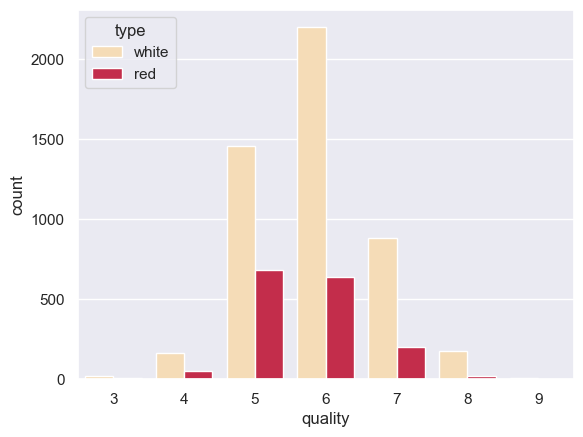

In [ ]:
# посмотрим на распределение по типу вина
sns.set(style="darkgrid")
sns.countplot(x='quality',hue='type', data=df, palette= ['navajowhite', 'crimson'])
plt.show()

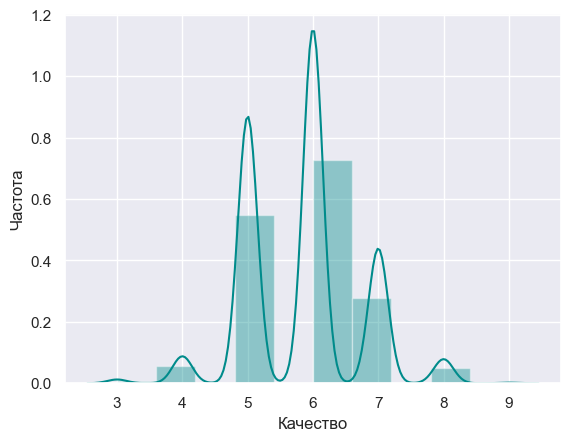

In [ ]:
# посмотрим на гистограмму датасета по качеству вина
sns.set()
sns.distplot(df["quality"],bins=10, color="darkcyan")
plt.xlabel('Качество')
plt.ylabel('Частота')
plt.show()

In [ ]:
# посмотрим на доли оценок
for val in np.sort(df['quality'].unique()):
    print(val, 'доля вхождения в выборку', int(df['quality'].value_counts()[val])/df.shape[0])

3 доля вхождения в выборку 0.0046175157765122364
4 доля вхождения в выборку 0.0332461135908881
5 доля вхождения в выборку 0.32907495767277206
6 доля вхождения в выборку 0.43650915807295676
7 доля вхождения в выборку 0.1660766507618901
8 доля вхождения в выборку 0.02970601816222872
9 доля вхождения в выборку 0.0007695859627520394


Построим «ящики с усами» для выявления аномалий

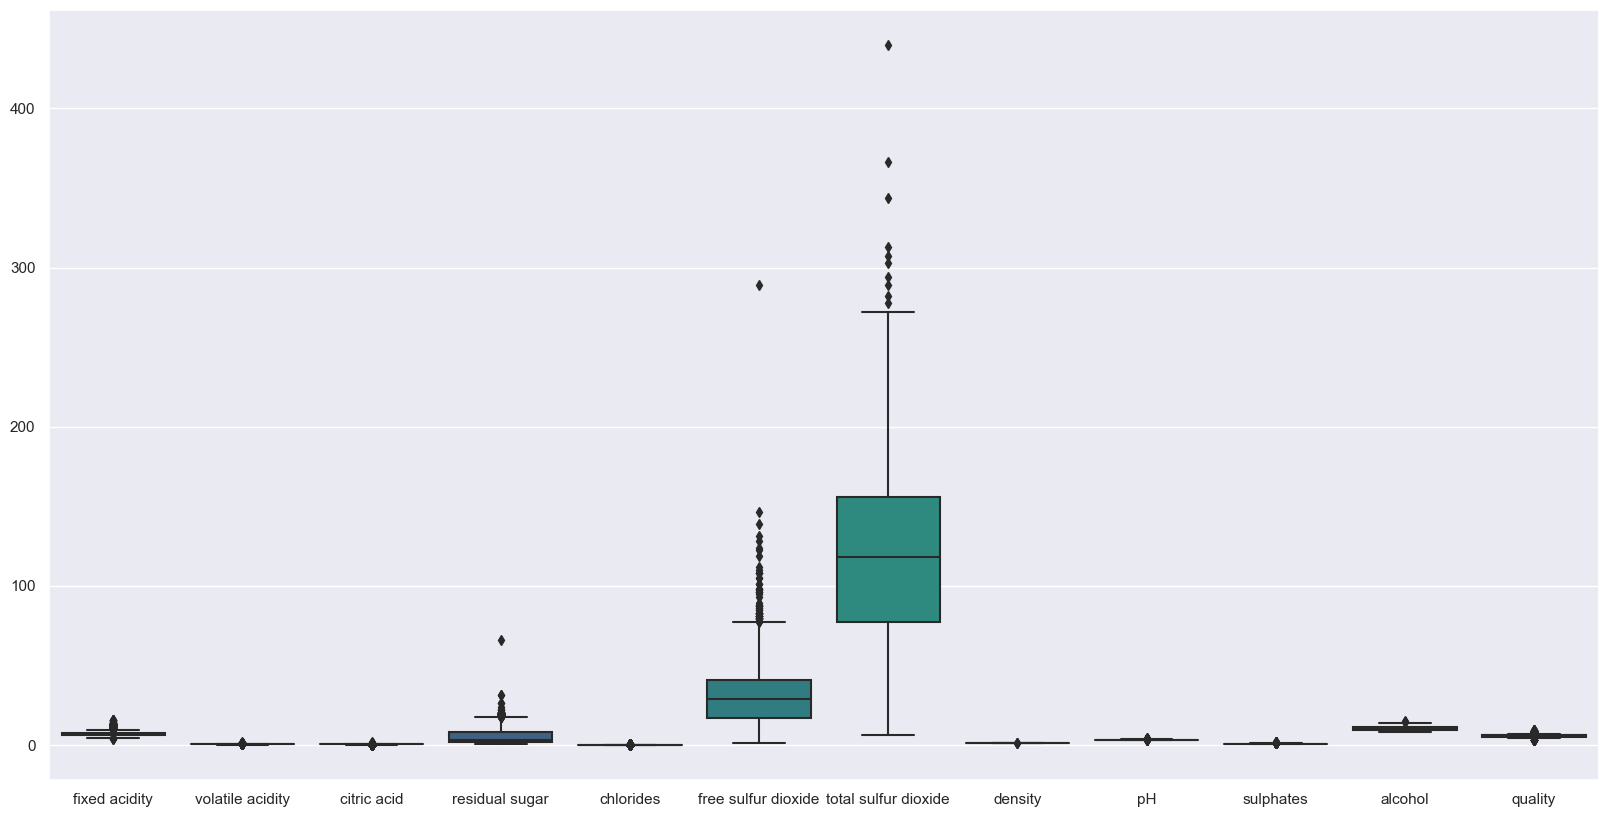

In [ ]:
sns.set()
plt.figure(figsize=(20,10))
sns.boxplot(data=df,palette="viridis")
plt.show()

Удалим аномалии из датасета. Для этого напишем функцию `normalization` используя правило 3-х сигм.

In [ ]:
def normalization(df, columns):
    for i in columns:
        low_lim = df[i].mean() - 3*df[i].std()
        up_lim = df[i].mean() + 3*df[i].std()
        print(f'Предельные значения для {i} = {low_lim}, {up_lim}')
        df = df[(df[i] > low_lim) & (df[i] < up_lim)]
    return df

Предельные значения для free sulfur dioxide = -22.722879937833156, 83.77351869418224
Предельные значения для total sulfur dioxide = -53.15243132839596, 283.65436601342924
Предельные значения для residual sugar = -8.838077345045534, 19.714650013158373


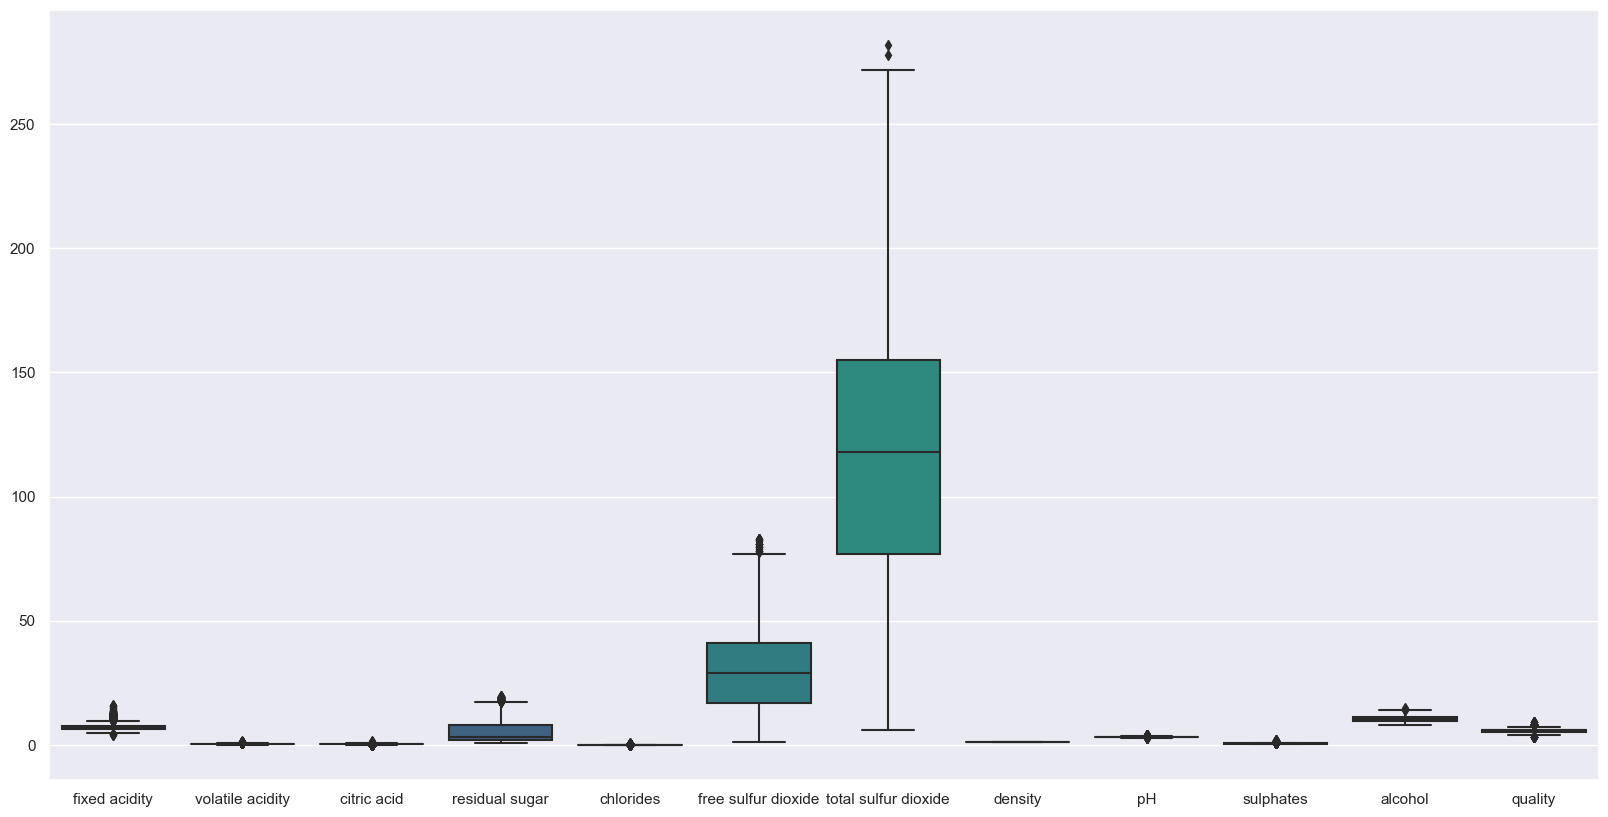

In [ ]:
df = normalization(df, columns =["free sulfur dioxide", "total sulfur dioxide", "residual sugar"])

sns.set()
plt.figure(figsize=(20,10))
sns.boxplot(data=df,palette="viridis")
plt.show()

**3. Выявление зависимостей**

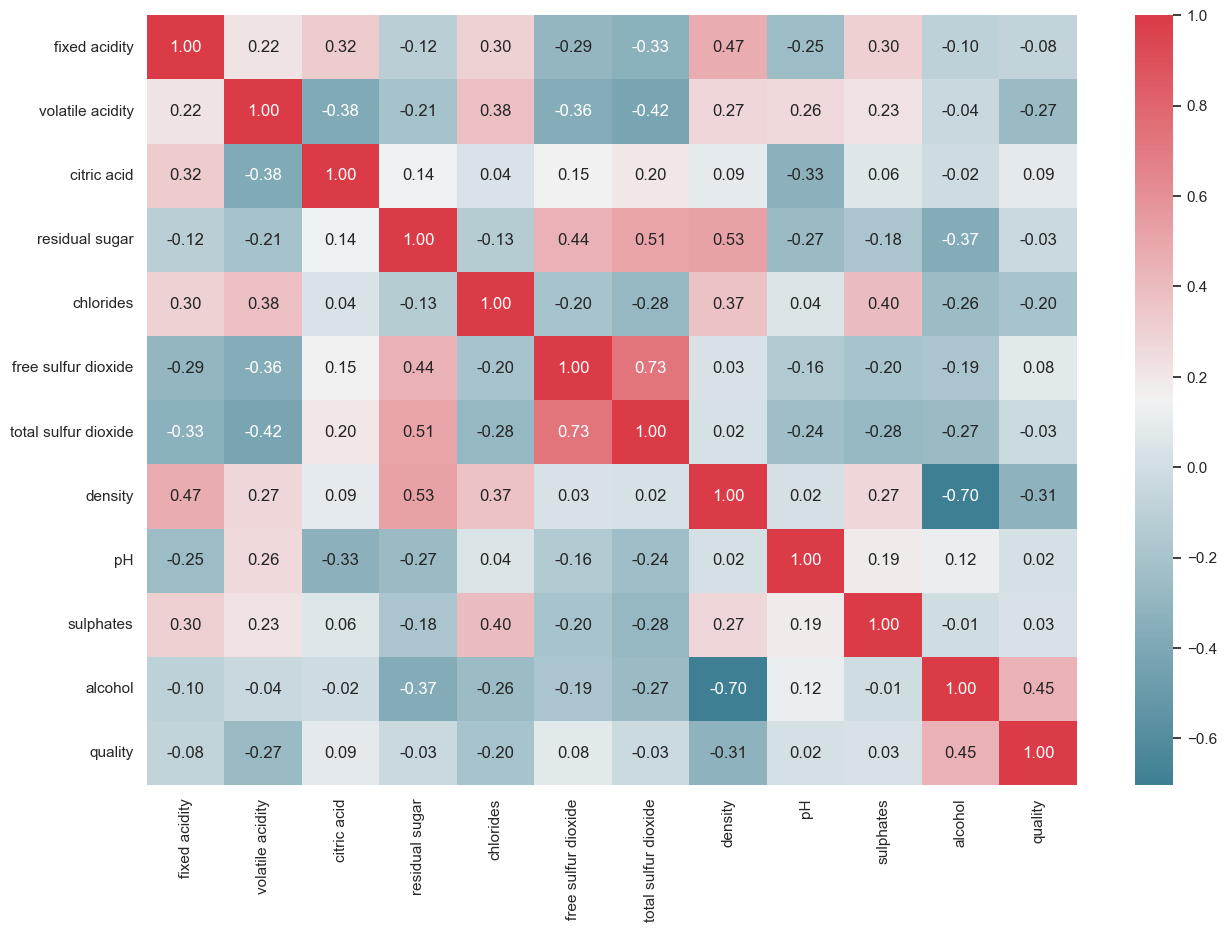

In [ ]:
# построим матрицу корреляций
correlation_matrix = df.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(correlation_matrix, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f" );

Корреляции между `free sulfur dioxide` и `total sulfur dioxide` = 0.73, `density`и `type` = 0.73, `density` и `alcohol` = -0.70 откуда следует что размерность исходного пространства следует уменьшить, для этого далее воспользуемся МГК.

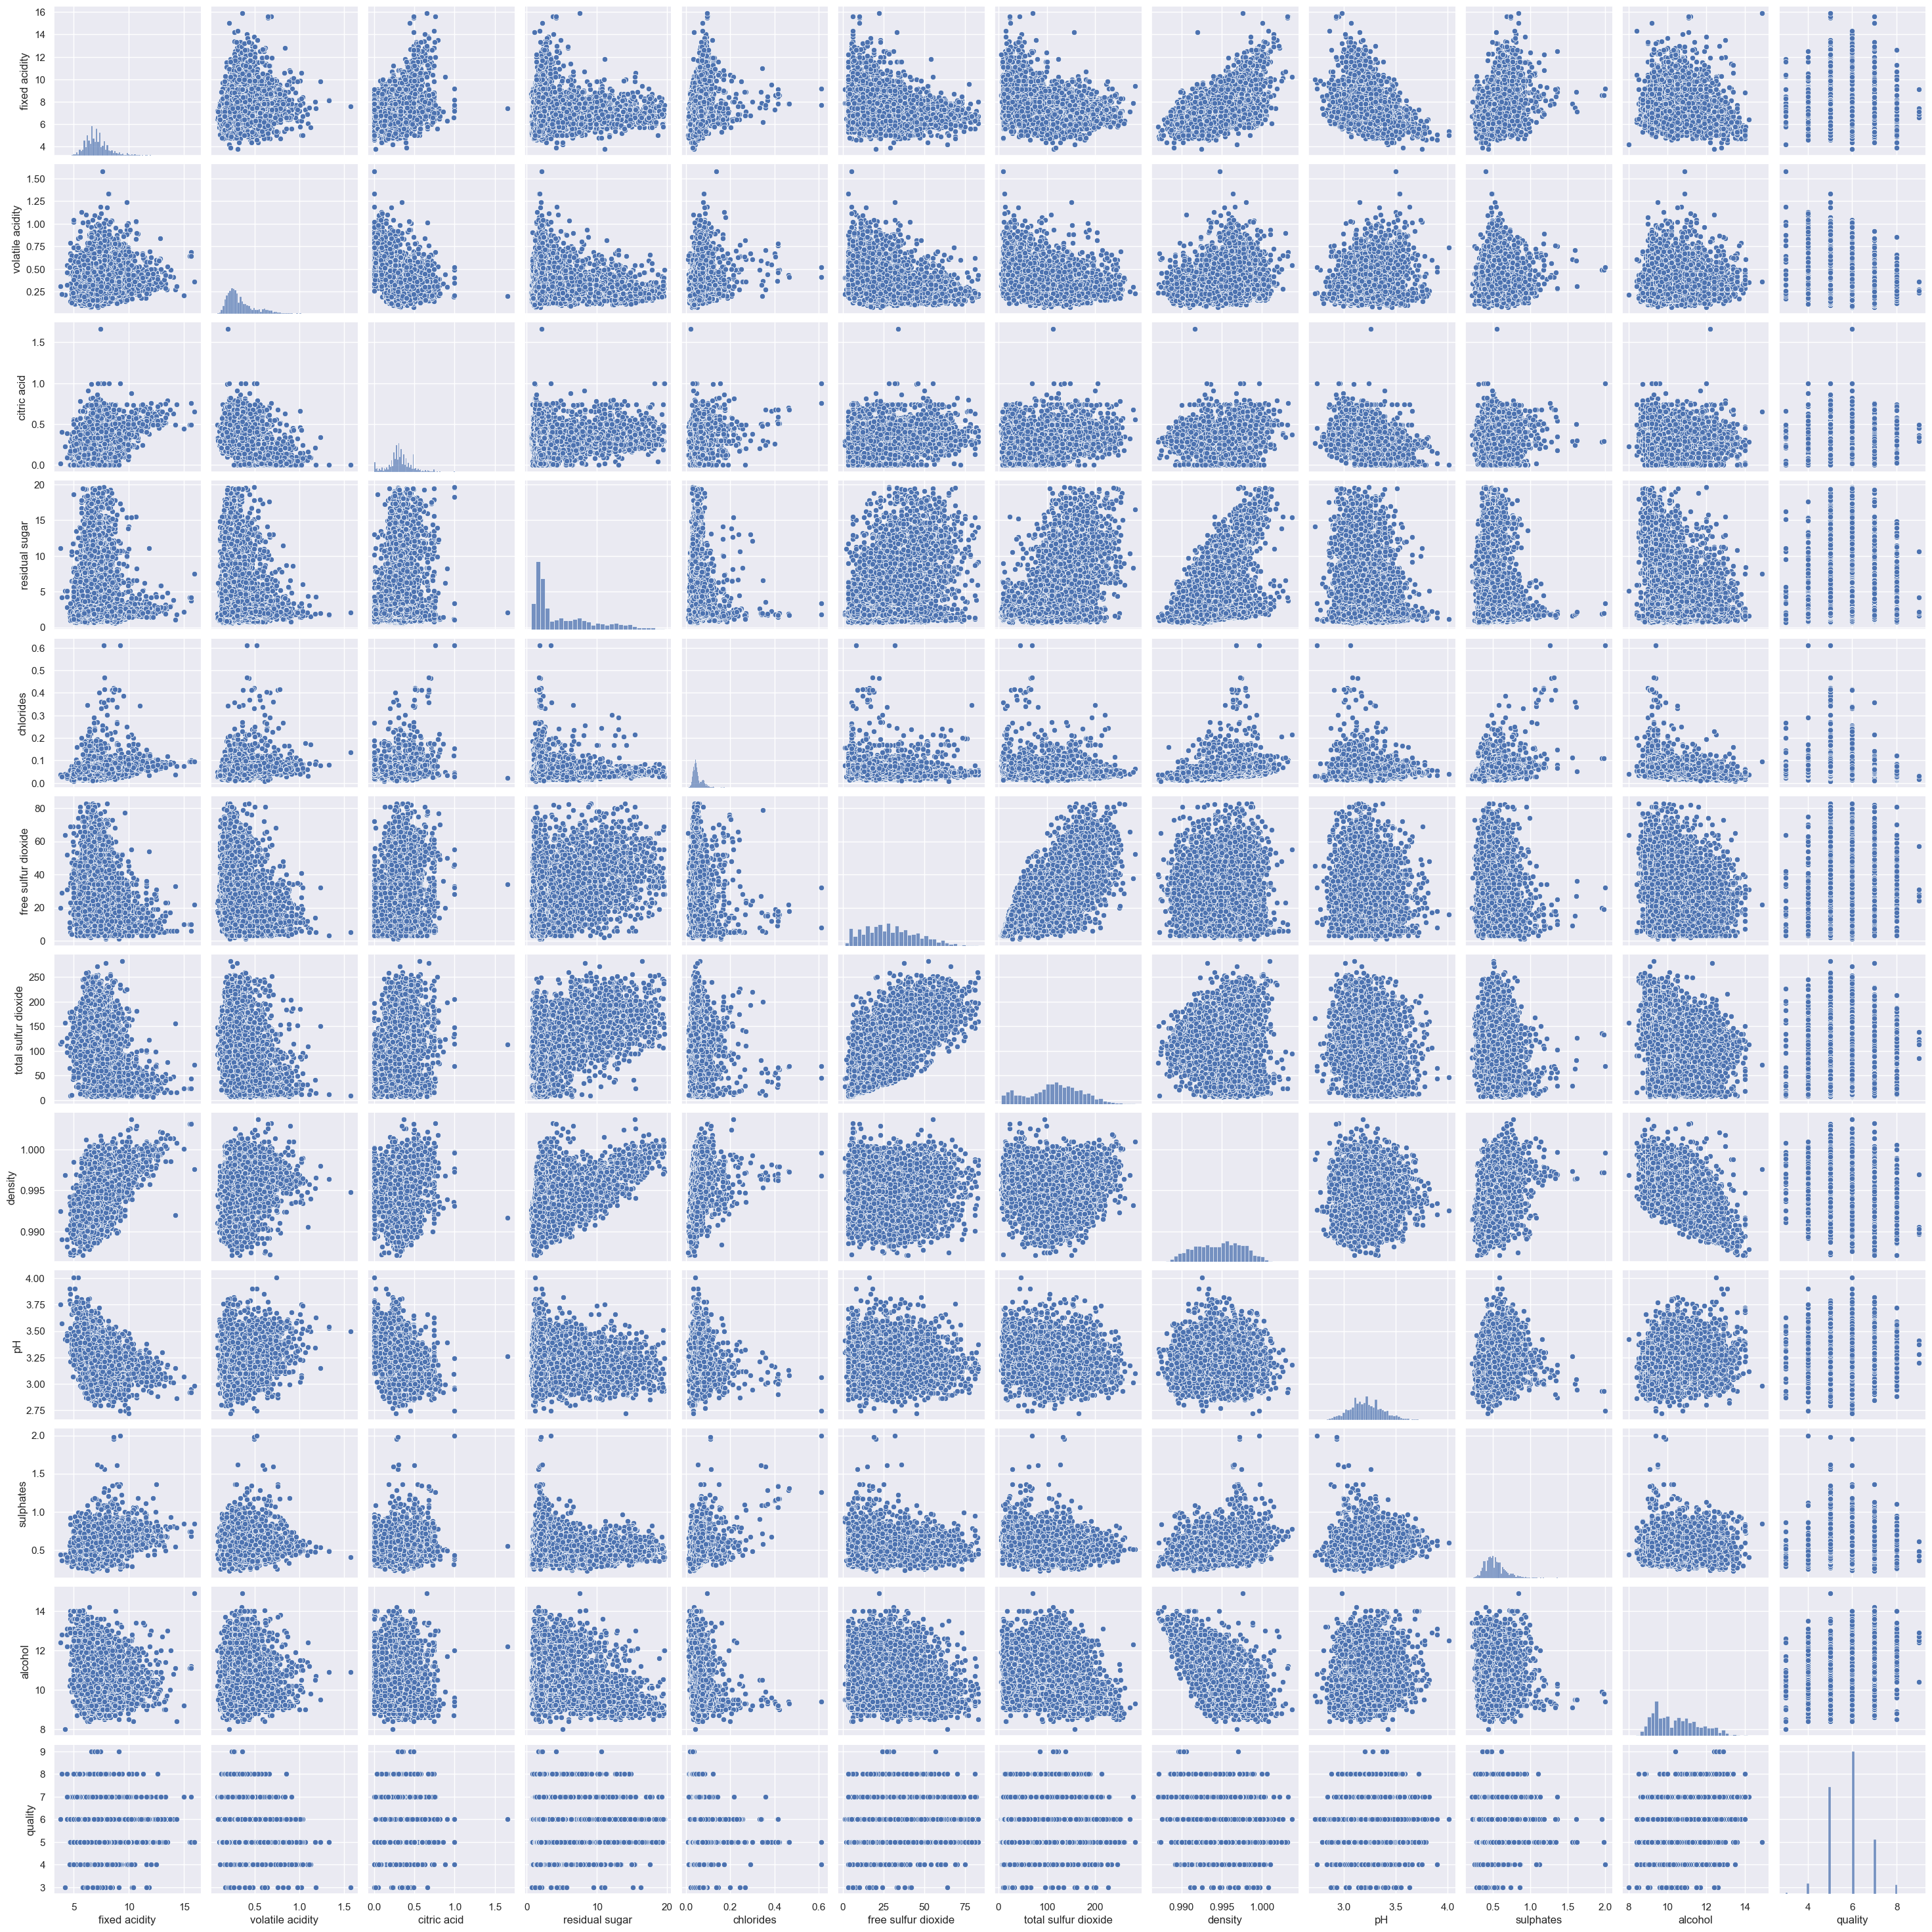

In [ ]:
sns.set()
sns.pairplot(df, palette='viridis')
plt.show()

**5. Заполнение пропусков**

С помощью `msno.matrix` выведем матрицу пропусков, которая повторяет структуру нашего датасета, где чёрным закрашены заполненные значения, а белым — пропуски.

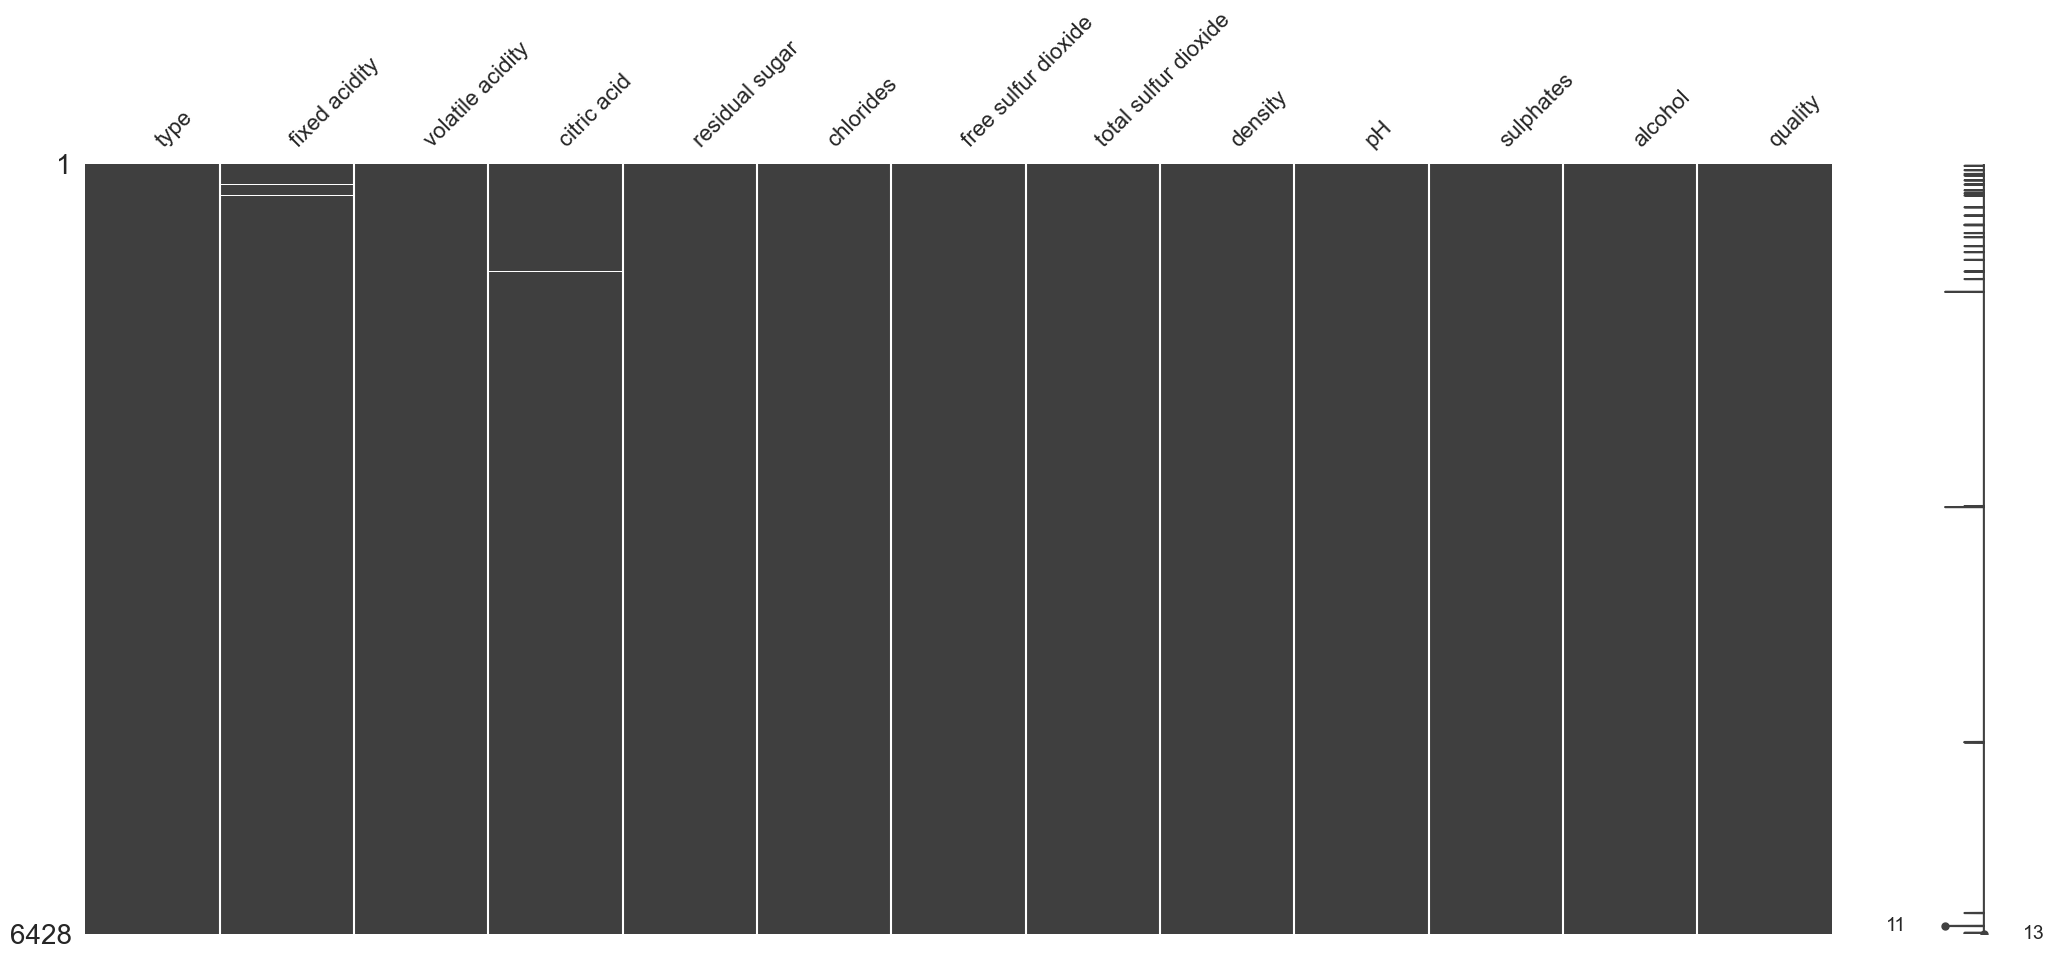

In [ ]:
msno.matrix(df);

In [ ]:
print('Количество полностью заполненных объектов из всей выборки:', len(df.dropna()))
print('Процент полностью заполненных объектов из всей выборки:', round(len(df.dropna()) / len(df) * 100, 2))

Количество полностью заполненных объектов из всей выборки: 6396
Процент полностью заполненных объектов из всей выборки: 99.5


Так как мало объектов не заполнены полностью, просто удалим их из нашего датасета.

In [ ]:
df.dropna(inplace=True)
df.isnull().sum()

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

**4. Преобразование категориальных данных и Стандартизация**

In [ ]:
# функция реальзующая стандартизацию данных
def standardization(X_train, X_test):
    std_scaler = StandardScaler()
    X_train = pd.DataFrame(std_scaler.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(std_scaler.transform(X_test), columns=X_train.columns)
    return X_train, X_test

# функция кодирование категориальных признаков
def encoder(df):
    le = LabelEncoder()
    df['type'] = le.fit_transform(df.type.values)
    return df

In [ ]:
df = encoder(df)
df.type

1       1
2       1
3       1
4       1
5       1
       ..
6491    0
6492    0
6494    0
6495    0
6496    0
Name: type, Length: 6396, dtype: int32

In [ ]:
# Отделяем целевую переменную
X = df.drop(['quality'], axis=1)
y = df.quality

X, _  =  standardization(X, X)

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

X_train, X_test = standardization(x_train, x_test)

## Метод главных компонент (МГК)

Подберем оптимальное число главных компонент

In [ ]:
# Функция для определения оптимального числа главных компонент

def optimal_components(X, variance_threshold=0.95): 
    # Применение PCA
    pca = PCA(n_components= X.shape[1])
    X_pca = pca.fit(X)
    # Кумулятивная сумма объясненной дисперсии
    explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
    # Возвращение оптимального числа главных компонент
    optimal = np.argmax(explained_variance_ratio >= variance_threshold) + 1
    return optimal

Напишем функции для построения графиков счетов и нагрузок

In [ ]:
# Функция для построения графиков счетов и нагрузок с использованием seaborn
def plot_pca_scores_and_loadings(X, num_components):
    pca = PCA(n_components=num_components)
    scores = pca.fit_transform(X)
    loadings = pca.components_.T

    # График счетов
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=scores[:, 0], y=scores[:, 1], hue=y, palette='viridis')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA Scores')
    plt.show()

    # График нагрузок
    plt.figure(figsize=(10, 6))
    sns.barplot(x=X.columns, y=loadings[:, 0])
    plt.xlabel('Features')
    plt.ylabel('Loadings')
    plt.title('PCA Loadings')
    plt.xticks(rotation=60)
    plt.show()

9


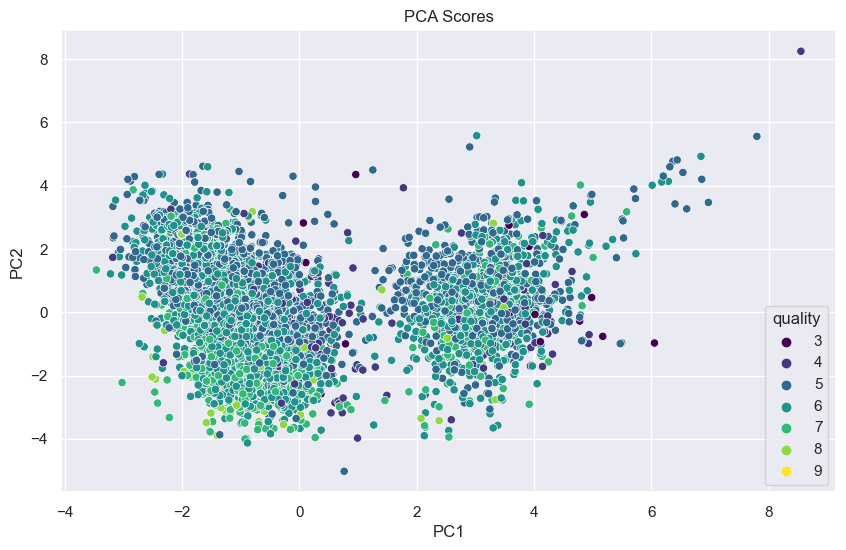

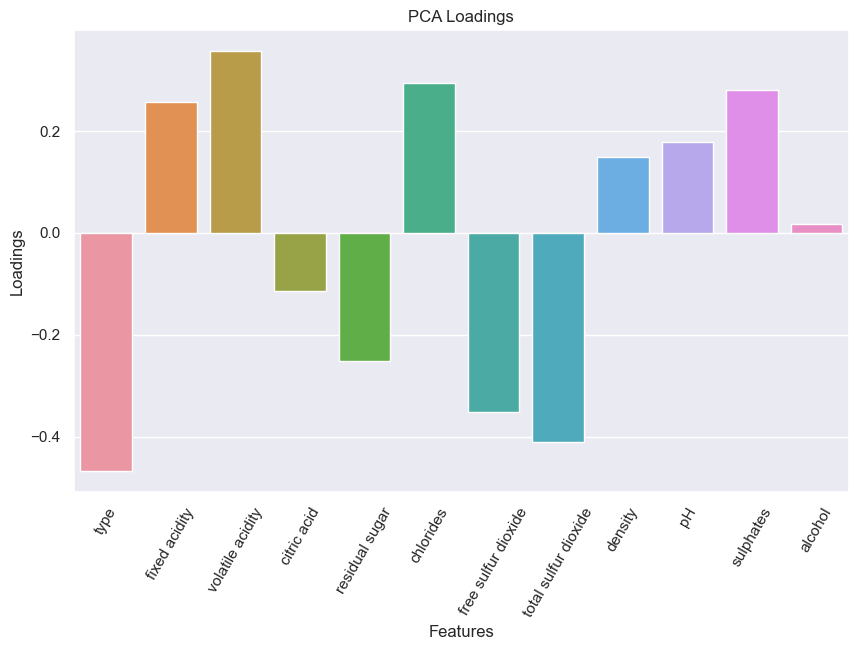

In [ ]:
# Построение графиков счетов и нагрузок
n = optimal_components(X, variance_threshold=0.95)
print(n)
plot_pca_scores_and_loadings(X, n)

In [ ]:
# воспользуемся понижением размерности
pca = PCA(n_components=n)
X_train1 = pca.fit_transform(X_train)
X_test1 = pca.transform(X_test)

## Предсказание качества алкоголя

Для подготовленных данных реализуем обучение Нейронной сети для задачи классификации и сравним с Решающими деревьями из бибилиотеки Sklearn.

In [ ]:
lr1=LogisticRegression()
reg=lr1.fit(X_train,y_train)
pred=lr1.predict(X_test)

In [ ]:
lr2=LogisticRegression()
reg1=lr2.fit(X_train1,y_train)
pred1=lr2.predict(X_test1)

In [ ]:
accuracy_score(y_test, pred1)

0.52109375

In [ ]:
accuracy_score(y_test, pred)

0.521875